<a href="https://colab.research.google.com/github/AraiKensuke/LOST/blob/master/Notebooks/ARdecomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import importlib

if importlib.util.find_spec("LOST") is None:
  %cd /content
  !git clone https://github.com/AraiKensuke/LOST.git
  %cd /content/LOST

!python setup.py build_ext --inplace

sys.path.insert(1, "/content/LOST")    #  add these to searchpath for python modules
sys.path.insert(1, "/content/pyPG")    #  add these to searchpath for python modules


#from google.colab import files
#uploaded = files.upload()

/content
Cloning into 'LOST'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (408/408), done.
remote: Compressing objects: 100% (301/301), done.
remote: Total 549 (delta 202), reused 276 (delta 103), pack-reused 141
Receiving objects: 100% (549/549), 28.98 MiB | 27.76 MiB/s, done.
Resolving deltas: 100% (273/273), done.
/content/LOST
running build_ext
cythoning kfARlibMPmv_ram2.pyx to kfARlibMPmv_ram2.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/LOST/kfARlibMPmv_ram2.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'kfARlibMPmv_ram2' extension
creating build
creating build/temp.linux-x86_64-3.7
/usr/bin/gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-securit

In [39]:
import numpy.polynomial.polynomial as _Npp
from LOST.kflib import createDataAR
import scipy.stats as _ss
from LOST.ARcfSmplFuncs import ampAngRep, buildLims, FfromLims, dcmpcff, initF
import LOST.commdefs as _cd
import LOST.practice.buildsignal as _blds
import matplotlib.pyplot as _plt

ram = True
import numpy as _N
_N.random.seed(12)

if ram:
    import LOST.ARcfSmplNoMCMC_ram as _arcfs
else:
    import LOST.ARcfSmplNoMCMC as _arcfs
from LOST.ARcfSmplNoMCMC import ARcfSmpl, FilteredTimeseries

def getComponents(uts, wts, allalfas, it0, it1):
    ddN   = N
    
    rts = _N.empty((ITER, TR, ddN+1, R, 1))    #  real components   N = ddN
    zts = _N.empty((ITER, TR, ddN+1, Cn+Cs, 1))    #  imag components 


    for it in range(it0, it1):
        for tr in range(TR):
            b, c = dcmpcff(alfa=allalfas[it])
            for r in range(R):
                rts[it, tr, :, r] = b[r] * uts[it, tr, r, :]
            
            for z in range(Cn+Cs):
                #print "z   %d" % z
                cf1 = 2*c[2*z].real
                gam = allalfas[it, R+2*z]
                cf2 = 2*(c[2*z].real*gam.real + c[2*z].imag*gam.imag)
                zts[it, tr, 0:ddN+1, z] = cf1*wts[it, tr, z, 1:ddN+2] - cf2*wts[it, tr, z, 0:ddN+1]
    return rts, zts


freq_order    = True
ARord         = _cd.__NF__

#  guessing AR coefficients of this form
Cn      = 8   # noise components
#Cn      = 2   # noise components
Cs      = 0
#Cs      = 1
R       = 2

k     = 2*(Cn + Cs) + R
#N     =  6000
#N     =  600
#N = 1200
N = 550
TR    = 1

dt = 0.001
#dt = 0.003333
#dat    = "twoAR1l"
#__obsvd = _N.loadtxt("practice/%s.dat" % dat)
#__obsvd = _N.loadtxt("practice/eeg_bp.dat")
__obsvd = _N.loadtxt("practice/eeg.dat")
#__obsvd = _N.loadtxt("practice/rideSlow1.dat")
shp = __obsvd.shape
nComps = shp[1]-1
#nComps = 1
#_obsvd = __obsvd[::3, nComps]
#_obsvd = __obsvd[:, nComps]
#_obsvd = __obsvd[::2, 0]
#_obsvd = __obsvd[:, 0]
_obsvd = __obsvd[::2, 15]
obsvd = _N.empty((1, N+100))
#obsvd[0] = _obsvd[4800:4800+N+100]
obsvd[0] = _obsvd[12500:12500+N+100]
#obsvd[0] = _obsvd[2000:2000+N+100]


fSigMax       = 500.    #  fixed parameters
#fSigMax       = 150.    #  fixed parameters
#freq_lims     = [[1 / .85, fSigMax]]
freq_lims     = [[0.000001, fSigMax]]*Cs

sig_ph0L      = -1
sig_ph0H      = -(0.05*0.05)#95*0.95)   #  
#sig_ph0H      = -(0.9*0.9)   #

radians      = buildLims(Cn, freq_lims, nzLimL=0.1)
AR2lims      = 2*_N.cos(radians)

F_alfa_rep  = initF(R, Cs, Cn).tolist()   #  init F_alfa_rep

if ram:
    alpR        = _N.array(F_alfa_rep[0:R], dtype=_N.complex)
    alpC        = _N.array(F_alfa_rep[R:], dtype=_N.complex)
    alpC_tmp    = _N.array(F_alfa_rep[R:], dtype=_N.complex)
else:
    alpR        = F_alfa_rep[0:R]
    alpC        = F_alfa_rep[R:]
    alpC_tmp        = list(F_alfa_rep[R:])
q2          = _N.array([0.01])

smpx        = _N.empty((TR, N+2, k))

#  q2  --  Inverse Gamma prior
#a_q2         = 0.5;          B_q2         = 1e-2
a_q2         = 0.5;          B_q2         = 1.

MS          = 1
#ITER        = 2
ITER        = 1000

fs           = _N.empty((ITER, Cn + Cs))
rs           = _N.empty((ITER, R))
amps         = _N.empty((ITER, Cn + Cs))
q2s          = _N.empty(ITER)
uts          = _N.empty((ITER, TR, R, N+1, 1))
wts          = _N.empty((ITER, TR, Cn+Cs, N+2, 1))

#  oo.smpx[:, 1+oo.ignr:, 0:ook], oo.smpx[:, oo.ignr:, 0:ook-1]
if ram:
    _arcfs.init(N, k, 1, R, Cs, Cn, aro=_cd.__NF__)
    smpx_contiguous1        = _N.zeros((TR, N + 1, k))
    smpx_contiguous2        = _N.zeros((TR, N + 2, k-1))

for n in range(N):
    smpx[0, n+2] = obsvd[0, n:n+k]
for m in range(TR):
    smpx[0, 1, 0:k-1]   = smpx[0, 2, 1:]
    smpx[0, 0, 0:k-2]   = smpx[0, 2, 2:]
if ram:
    _N.copyto(smpx_contiguous1, 
              smpx[:, 1:])
    _N.copyto(smpx_contiguous2, 
              smpx[:, 0:, 0:k-1])

allalfas     = _N.empty((ITER, k), dtype=_N.complex)
for it in range(ITER):
    if ram:
        uts[it], wts[it] = _arcfs.ARcfSmpl(N, k, 1, AR2lims, smpx_contiguous1, smpx_contiguous2, q2, R, Cs, Cn, alpR, alpC, sig_ph0L, sig_ph0H)
    else:
        uts[it], wts[it] = _arcfs.ARcfSmpl(N, k, AR2lims, smpx[:, 1:, 0:k], smpx[:, :, 0:k-1], q2, R, Cs, Cn, alpR, alpC, TR, aro=ARord, sig_ph0L=sig_ph0L, sig_ph0H=sig_ph0H)

    F_alfa_rep[0:R] = alpR
    F_alfa_rep[R:]  = alpC
    allalfas[it] = F_alfa_rep
    #F_alfa_rep = alpR + alpC   #  new constructed
    prt, rank, f, amp = ampAngRep(F_alfa_rep, 0.001, f_order=True)

    #  reorder
    
    if it % 50 == 0:
        print("iter %d -----------------" % it)
        print(prt)
    
    if freq_order:
        # coh = _N.where(amp > 0.95)[0]
        # slow= _N.where(f[coh] < f_thr)[0]
        # #  first, rearrange 

        #print(alpR)
        #print(alpC)
        for i in range(Cs+Cn):
            alpC_tmp[2*i] = alpC[rank[i]*2]
            alpC_tmp[2*i+1] = alpC[rank[i]*2+1]
        for i in range(Cs+Cn):
            alpC[2*i] = alpC_tmp[2*i]
            alpC[2*i+1] = alpC_tmp[2*i+1]

        amps[it, :]  = amp[rank]
        fs[it, :]    = 0.5*(f[rank]/dt)
    else:
        amps[it, :]  = amp
        fs[it, :]    = 0.5*(f/dt)

    rs[it]       = alpR

    F0          = (-1*_Npp.polyfromroots(F_alfa_rep)[::-1].real)[1:]

    a2 = a_q2 + 0.5*(TR*N + 2)  #  N + 1 - 1
    BB2 = B_q2
    for m in range(TR):
        #   set x00 
        rsd_stp = smpx[m, 3:,0] - _N.dot(smpx[m, 2:-1], F0).T
        BB2 += 0.5 * _N.dot(rsd_stp, rsd_stp.T)
    q2[:] = _ss.invgamma.rvs(a2, scale=BB2)


    q2s[it] = q2[0]

#clrs = ["black", "red", "green", "orange", "blue", "grey", "purple", "cyan", "brown"]



INIT ARcfSmplNoMCMC_ram
iter 0 -----------------
R  [ nan, ..]
R  [ nan, ..]



IndexError: ignored

**Now plot out the sampled AR roots.**
Each AR(2) component has an associated frequency and modulus.  The modulus roughly tells us how coherent and steady the oscillation is - if its near 1, the frequency is more steady from cycle to cycle.

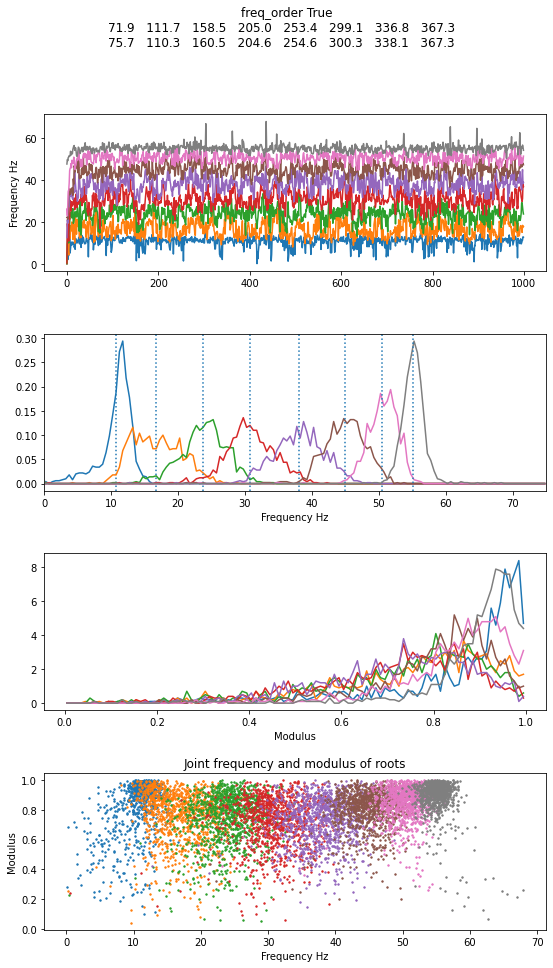

In [16]:

stat_str_mn = ""
stat_str_md = ""
if freq_order:
    ordrd_fs = fs
else:
    ordrd_fs = _N.sort(fs, axis=1)

fig = _plt.figure(figsize=(9, 15))
fig.add_subplot(4, 1, 1)
for ic in range(Cs+Cn):
    _plt.plot(ordrd_fs[:, ic]/6.66)#, color=clrs[ic])
_plt.ylabel("Frequency Hz")
fig.add_subplot(4, 1, 2)

dx = 1./500
#  int0^500 dx = 1
for ic in range(Cs+Cn):
    cnts, bins = _N.histogram(ordrd_fs[:, ic]/6.66, bins=_N.linspace(0, 75, 151), density=True)
    _plt.plot(0.5*(bins[0:-1] + bins[1:]), cnts)#, color=clrs[ic])
    
    stat_str_mn += "%.1f   " % _N.mean(ordrd_fs[:, ic])
    stat_str_md += "%.1f   " % _N.median(ordrd_fs[:, ic])
    _plt.axvline(x=_N.mean(ordrd_fs[:, ic])/6.666, ls=":")#, color=clrs[ic])
_plt.xlim(0, 75)
_plt.xlabel("Frequency Hz")
fig.add_subplot(4, 1, 3)
for ic in range(Cs + Cn):
    cnts, bins = _N.histogram(amps[:, ic], bins=_N.linspace(0, 1, 101), density=True)
    _plt.plot(0.5*(bins[0:-1] + bins[1:]), cnts)#, color=clrs[ic])
_plt.xlabel("Modulus")
fig.add_subplot(4, 1, 4)
_plt.title("Joint frequency and modulus of roots")
for ic in range(Cs + Cn):
  _plt.scatter(fs[:, ic]/6.6666, amps[:, ic], s=2)
_plt.xlabel("Frequency Hz")
_plt.ylabel("Modulus")

_plt.suptitle("freq_order %(fo)s\n%(mn)s\n%(md)s\n" % {"fo" : str(freq_order), "mn" : stat_str_mn, "md" : stat_str_md})
fig.subplots_adjust(wspace=0.4, hspace=0.4)

rts, zts = getComponents(uts, wts, allalfas, 0, ITER)
#c1 = __obsvd[::3, 0]

z_stds = _N.std(zts[:, 0, :, :, 0], axis=1)
r_stds = _N.std(rts[:, 0, :, :, 0], axis=1)




Now let's look at the lowest root, and the AR(1) components.  The former captures the 12Hz oscillation and the latter the slower variability in the signal.

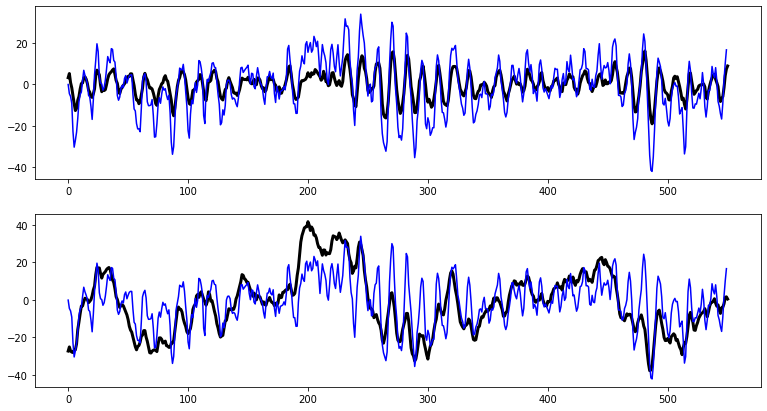

In [35]:
##  zts, rts contain the components.
mn_zts = _N.mean(zts[200:, 0, :, :, 0], axis=0)
mn_rts = _N.mean(rts[200:, 0, :, :, 0], axis=0)

fig = _plt.figure(figsize=(13, 7))
fig.add_subplot(2, 1, 1)
_plt.title("Black is slowest AR(2) component.  Blue is original EEG.")
_plt.plot(mn_zts[:, 0], lw=3, color="black")
_plt.plot(obsvd[0, 0:N], color="blue")
fig.add_subplot(2, 1, 2)
_plt.title("sum AR(1) components".  Blue is original EEG.)
_plt.plot(mn_rts[:, 0] + mn_rts[:, 1], lw=3, color="black")
_plt.plot(obsvd[0, 0:N], color="blue")